### Author
0001128790 - Christian Di Buò - christian.dibuo@studio.unibo.it

### Importing images

In [356]:
import os, json
import subprocess, sys
import random
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchmetrics.segmentation import MeanIoU
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import TrainingArguments, Trainer, MobileViTImageProcessor, MobileViTForSemanticSegmentation, EarlyStoppingCallback
from tqdm import tqdm

In [357]:
package_name = "evaluate"

try:
    __import__(package_name)
    print('already installed')
except ImportError:
    print(f"{package_name} is NOT installed! Installing now...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package_name]);

already installed


In [358]:
x = torch.tensor([0, 1, 2, 3, 4])
torch.save(x, "tensor.pt")
print('saved')
y = torch.load('/kaggle/working/tensor.pt', weights_only=True)
print('loaded: ',y)

saved
loaded:  tensor([0, 1, 2, 3, 4])


In [359]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=42)

In [360]:
import evaluate

"""
Source: https://github.com/hendrycks/anomaly-seg/issues/15#issuecomment-890300278
"""
COLORS = np.array([
    [  0,   0,   0],  # unlabeled    =   0,
    [ 70,  70,  70],  # building     =   1,
    [190, 153, 153],  # fence        =   2, 
    [250, 170, 160],  # other        =   3,
    [220,  20,  60],  # pedestrian   =   4, 
    [153, 153, 153],  # pole         =   5,
    [157, 234,  50],  # road line    =   6, 
    [128,  64, 128],  # road         =   7,
    [244,  35, 232],  # sidewalk     =   8,
    [107, 142,  35],  # vegetation   =   9, 
    [  0,   0, 142],  # car          =  10,
    [102, 102, 156],  # wall         =  11, 
    [220, 220,   0],  # traffic sign =  12,
    [ 60, 250, 240],  # anomaly      =  13,
]) 

In [361]:
class StreetHazardsDataset(Dataset):
    def __init__(self, odgt_file, transform1=None, transform2=None):
        """
        Args:
            odgt_file (str): Path to the .odgt file (train, val, or test).
            transform (callable, optional): Transformations to apply to images and masks.
        """

        self.transform1 = transform1
        self.transform2 = transform2

        # Load the .odgt file
        with open(odgt_file, "r") as f:
            odgt_data = json.load(f)

        self.paths = [
            {
                "image": os.path.join(Path(odgt_file).parent, data["fpath_img"]),
                "annotation": os.path.join(Path(odgt_file).parent, data["fpath_segm"]),
            }
            for data in odgt_data 
        ]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):

        # Build full paths for image and mask
        image = Image.open(self.paths[idx]["image"]).convert("RGB")
        annotation = Image.open(self.paths[idx]["annotation"])

        if self.transform1:
            image = self.transform1(image)
            annotation = torch.as_tensor(transforms.functional.pil_to_tensor(annotation), dtype=torch.int64) - 1 # Make class indexes start from 0
            annotation = self.transform2(annotation).squeeze(0)

        return {'image' : image, 'labels' : annotation}


def visualize_annotation(annotation_img: np.ndarray|torch.Tensor, ax=None):
    """
    Adapted from https://github.com/CVLAB-Unibo/ml4cv-assignment/blob/master/utils/visualize.py
    """
    if ax is None: ax = plt.gca()
    annotation_img = np.asarray(annotation_img)
    img_new = np.zeros((*annotation_img.shape, 3))

    for index, color in enumerate(COLORS):
        img_new[annotation_img == index] = color

    ax.imshow(img_new / 255.0)
    ax.set_xticks([])
    ax.set_yticks([])

def visualize_scene(image: np.ndarray|torch.Tensor, ax=None):
    if ax is None: ax = plt.gca()
    image = np.asarray(image)
    ax.imshow(np.moveaxis(image, 0, -1))
    ax.set_xticks([])
    ax.set_yticks([])



In [362]:
transform1 = transforms.Compose([
    transforms.Resize((520, 520), transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

transform2 = transforms.Compose([
    transforms.Resize((520, 520), transforms.InterpolationMode.NEAREST)
])

# Create dataset instance
train_dataset = StreetHazardsDataset(
    odgt_file="/kaggle/input/ml4cv-data/streethazards_train/train/train.odgt",
    transform1=transform1,
    transform2=transform2
)
val_dataset = StreetHazardsDataset(
    odgt_file="/kaggle/input/ml4cv-data/streethazards_train/train/validation.odgt",
    transform1=transform1,
    transform2=transform2
)
test_dataset = StreetHazardsDataset(
    odgt_file="/kaggle/input/ml4cv-data/streethazards_test/test/test.odgt",
    transform1=transform1,
    transform2=transform2
)

torch.Size([520, 520]) 1500


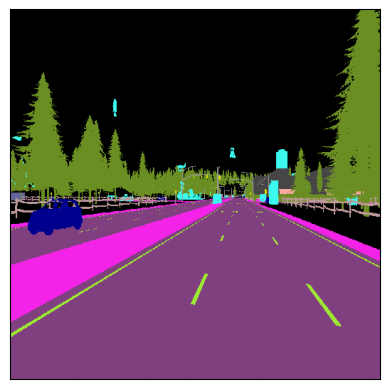

In [363]:
idx = random.randint(0, len(test_dataset))
print(test_dataset[idx]['labels'].shape, len(test_dataset))
visualize_annotation(test_dataset[idx]['labels'])

In [364]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [365]:
def get_model(model_name, num_classes, weights_path = None):
    
    if not weights_path:
        weights_path = model_name
        
    feature_extractor = MobileViTImageProcessor.from_pretrained(model_name)
    model = MobileViTForSemanticSegmentation.from_pretrained(weights_path, num_labels=num_classes, ignore_mismatched_sizes=True, semantic_loss_ignore_index = 13)
    
    model.to(DEVICE);
    
    return model

In [366]:
class MeanIoU:
    """
    taken from https://github.com/Jun-CEN/Open-World-Semantic-Segmentation/blob/main/DeepLabV3Plus-Pytorch/metrics/stream_metrics.py
    """
    def __init__(self, n_classes= 13):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))
        
    def update(self, label_trues, logits):
        logits = F.interpolate(logits, size=label_trues.shape[1:], mode='bilinear', align_corners=False)
        label_preds = torch.argmax(logits, dim=1)
        label_preds, label_trues = label_preds.cpu().numpy(), label_trues.cpu().numpy()
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist( lt.flatten(), lp.flatten())

    def _fast_hist(self, label_true, label_pred):
        mask = (label_true >= 0) & (label_true < self.n_classes)
        hist = np.bincount(
            self.n_classes * label_true[mask].astype(int) + label_pred[mask],
            minlength=self.n_classes ** 2,
        ).reshape(self.n_classes, self.n_classes)
        return hist

    def get_results(self):
        """Returns accuracy score evaluation result.
            - overall accuracy
            - mean accuracy
            - mean IU
            - fwavacc
        """
        hist = self.confusion_matrix
        acc = np.diag(hist).sum() / hist.sum()
        acc_cls = np.diag(hist) / hist.sum(axis=1)
        acc_cls = np.nanmean(acc_cls)
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu, axis= 0)
        freq = hist.sum(axis=1) / hist.sum()
        fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
        cls_iu = dict(zip(range(self.n_classes), iu))

        return {
                "Overall Acc": acc,
                "Mean Acc": acc_cls,
                "FreqW Acc": fwavacc,
                "Mean IoU": mean_iu,
                "Class IoU": cls_iu,
            }


In [367]:
class Trainer:
    def __init__(self,
                 model: nn.Module,
                 train_loader: DataLoader,
                 val_loader: DataLoader,
                 device: torch.device,
                 num_classes: int,
                 cfg: dict,
                 model_name: str,
                 resume_ckpt: dict = None,
                 
        ) -> None:
        
        self.model_name = model_name
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        
        self.patience = cfg["patience"]
        
        if resume_ckpt:
            self.mean_iou = cfg['mean_iou']
            self.num_epochs = cfg["num_epochs"] - resume_ckpt['epoch']
            #self.loss = 
            self.model = resume_ckpt['model_state_dict']
            self.optimizer = resume_ckpt['optimizer_state_dict']
            self.scheduler = resume_ckpt['scheduler_state_dict']

        else:
            self.mean_iou = 0.0
            self.num_epochs = cfg["num_epochs"]
            self.model = model.to(device)
            self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
            num_steps = self.num_epochs * len(train_loader)
            self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, cfg["lr"], total_steps=num_steps)
        
        self.step = 0
        self.best_acc = 0.0

        #wandb.init(name=cfg["run_name"], entity=WANDB_USER, project=WANDB_PROJECT, config=cfg)
        self.ckpt_path = Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True)

    '''def logfn(self, values: Dict[str, Any]) -> None:
        wandb.log(values, step=self.step, commit=False)'''

    def train(self, verbose= False) -> None:
        for epoch in tqdm(range(self.num_epochs), desc="Epoch"):
            self.model.train()

            for batch in next(iter(loader)):
                imgs = batch['image'].to(self.device)
                labels = batch['labels'].to(self.device)

                pred = self.model(imgs)
                loss = F.cross_entropy(pred, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                '''if self.step % 10 == 0:
                    self.logfn({"train/loss": loss.item()})
                    self.logfn({"train/lr": self.scheduler.get_last_lr()[0]})'''

            self.eval("train", epoch)
            self.eval("val", epoch)

            if self.patience < self.step:
                break

        #wandb.finish()

    @torch.no_grad()
    def eval(self, split: str, epoch: int) -> None:
        self.model.eval()

        loader = self.train_loader if split == "train" else self.val_loader
        
        mean_iou = MeanIoU()
        losses = []

        for batch in next(iter(loader)):
            imgs = batch['image'].to(self.device)
            labels = batch['labels'].to(self.device)

            pred = self.model(imgs)
            loss = F.cross_entropy(pred, labels)
            losses.append(loss.item())

            mean_iou.update(labels, pred['logits'])

        results = mean_iou.get_results()
        mean_iou = results['Mean IoU']
        loss = sum(losses) / len(losses)

        #self.logfn({f"{split}/loss": loss})
        #self.logfn({f"{split}/acc": accuracy})

        if mean_iou > self.mean_iou and split == "val":
            self.mean_iou = mean_iou
            #torch.save(self.model.state_dict(), self.ckpt_path / f"{wandb.run.name}.pt")
            #saving the best model configuration
            torch.save(self.model.state_dict(), self.ckpt_path / "model_weights"/f"{self.model_name}.pt")
            #save everything to restart
            torch.save({
                'epoch': epoch,
                'mean_iou': self.mean_iou,
                #'loss': loss,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                }, self.ckpt_path / "best_checkpoint")
            
            self.best_model = copy.deepcopy(self.model)
            self.step = 0

        else:
            self.step += 1
    
    @torch.no_grad()
    def predict(self, loader, verbose= False):

        self.model.eval()
        mean_iou = MeanIoU()
        
        for batch in tqdm(loader):
            imgs = batch['image'].to(self.device)
            labels = batch['labels'].to(self.device)
            pred = self.model(imgs)
            max_logit(pred['logits'])
            break
            mean_iou.update(labels, pred['logits'])


        return mean_iou.get_results()

In [368]:
def max_logit(logits):
    """
    create a function that taken the model predictions (pred.predictions) compute a softmax over them and whether the maximum is lower than a 
    threshold check the model averages prediction (model is not sure) classify it as an anomaly.
    """
    logits = F.interpolate(logits, size=(512, 512), mode='bilinear', align_corners=False)
    probabilities, label_preds = -1 * torch.max(logits, dim=1)
    for pro, lp, lo in zip (probabilities, label_preds, logits):
        print(pro.shape)
        print(lo.shape)
        break
    

### get the model

only specify the weights path if you do not want to train the model

In [369]:
model_name = "apple/deeplabv3-mobilevit-small"
weights_path = "/kaggle/input/weights/run_08_03_25 epochs 20-50"
model = get_model(model_name, num_classes = len(COLORS)-1, weights_path = weights_path)

In [370]:
train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_dl = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_dl = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

### model training

In [371]:
cfg = {
    "num_epochs" : 50,
    "lr": 2e-5,
    "wd": 0.01,
    "patience": 10,
}

In [372]:
trainer = Trainer(
    model= model,
    train_loader= train_dl,
    val_loader= val_dl ,
    device= DEVICE,
    num_classes = len(COLORS)-1,
    model_name = 'deeplab',
    cfg= cfg
)

In [373]:
results = trainer.predict(test_dl)

  0%|          | 0/188 [00:00<?, ?it/s]

torch.Size([512, 512])
torch.Size([13, 512, 512])


  0%|          | 0/188 [00:01<?, ?it/s]
<ipython-input-366-b5bc8cf094b4>:32: RuntimeWarning: invalid value encountered in scalar divide
  acc = np.diag(hist).sum() / hist.sum()
<ipython-input-366-b5bc8cf094b4>:33: RuntimeWarning: invalid value encountered in divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
<ipython-input-366-b5bc8cf094b4>:34: RuntimeWarning: Mean of empty slice
  acc_cls = np.nanmean(acc_cls)
<ipython-input-366-b5bc8cf094b4>:35: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
<ipython-input-366-b5bc8cf094b4>:36: RuntimeWarning: Mean of empty slice
  mean_iu = np.nanmean(iu, axis= 0)
<ipython-input-366-b5bc8cf094b4>:37: RuntimeWarning: invalid value encountered in divide
  freq = hist.sum(axis=1) / hist.sum()
<ipython-input-366-b5bc8cf094b4>:38: RuntimeWarning: invalid value encountered in greater
  fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()


In [374]:
results

{'Overall Acc': nan,
 'Mean Acc': nan,
 'FreqW Acc': 0.0,
 'Mean IoU': nan,
 'Class IoU': {0: nan,
  1: nan,
  2: nan,
  3: nan,
  4: nan,
  5: nan,
  6: nan,
  7: nan,
  8: nan,
  9: nan,
  10: nan,
  11: nan,
  12: nan}}

In [375]:
'''checkpoint_path = "/kaggle/input/weights"
epochs = 50
batch_size = 1
trained_model = train_model(model, epochs, batch_size, do_train = False, checkpoint_path = None)'''

'checkpoint_path = "/kaggle/input/weights"\nepochs = 50\nbatch_size = 1\ntrained_model = train_model(model, epochs, batch_size, do_train = False, checkpoint_path = None)'

### TODO: inside the train insert the patience (DONE)
### TODO: implement the checkpoint inside the training to resume from the log (remember to update, scheduler, optimizer and model weights .pt files) (DONE)
### TODO: make anomaly predictions using: 
    - max softmax probability
    - max logits
### TODO: create the metrics as class, not as function; you would like to have mean_iou and aupr